<a href="https://colab.research.google.com/github/vferman2000/Springboard/blob/master/Capstone2_InitialDataExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

from google.colab import drive 
drive.mount('/mntDrive')  

In [2]:
# importing additional libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import os

In [4]:
# Path to dataset in Google drive

DATASET_PATH = "/content/drive/My Drive/Springboard Data Science/CapstoneTwo/fashion-product-images-small/myntradataset/"
print(os.listdir(DATASET_PATH))


['images', 'styles.csv']


In [5]:
#Creating a Pandas DataFrame with styles.csv
#Some rows have an extra column in their productDisplayName which will be ommitted.

df_styles = pd.read_csv(DATASET_PATH + 'styles.csv', usecols = lambda column : column not in range(11))


In [6]:
print("There are", len(df_styles),"items in df_styles")
df_styles.head()

There are 44446 items in df_styles


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [7]:
df_styles.masterCategory.value_counts()

Apparel           21400
Accessories       11289
Footwear           9222
Personal Care      2404
Free Items          105
Sporting Goods       25
Home                  1
Name: masterCategory, dtype: int64

In [8]:
df_styles['image'] = df_styles.apply(lambda row: str(row['id']) + ".jpg", axis=1)


df_styles['masterCategory'] = df_styles.masterCategory.apply(lambda row: 'NA' if row is np.nan else row)
df_styles = df_styles.reset_index(drop=True)
print(len(df_styles))
df_styles.head(10)

44446


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch,30039.jpg


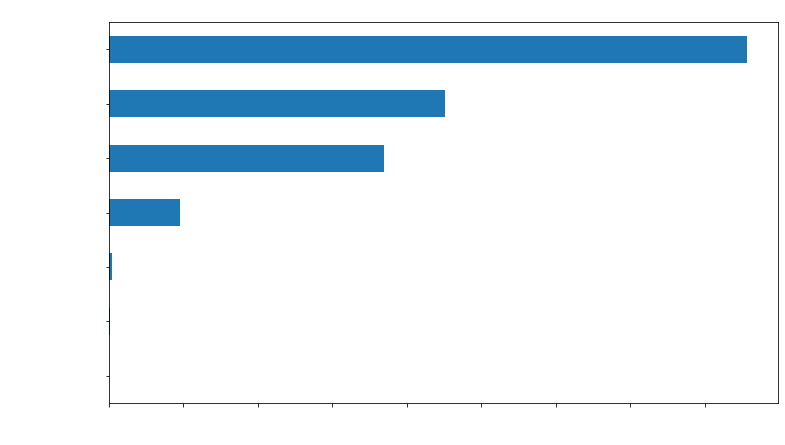

In [10]:
plt.figure(figsize=(12,7))
plt.title("Breakdown of target classes", c='white')
plt.ylabel("Classes", c="white", fontsize=14)
plt.xlabel("Number of items", c='white', fontsize=14)
plt.xticks(c='white')
plt.yticks(c='white')
df_styles.masterCategory.value_counts().sort_values().plot(kind='barh')

In [14]:
# There is only one sample in the Home category.  It will be omitted.
df_styles_labels = df_styles[df_styles.masterCategory != 'Home']

In [15]:
 def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.60, frac_val=0.20, frac_test=0.20,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_styles.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_validation, df_test, y_validation, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_validation) + len(df_test)

    return df_train, df_validation, df_test

In [16]:
df_train, df_validation, df_test = \
    split_stratified_into_train_val_test(df_styles_labels, stratify_colname='masterCategory', frac_train=0.60, frac_val=0.20, frac_test=0.20)

In [ ]:
print('The train subset has', len(df_train),'samples')
print('The validation subset has', len(df_validation),'samples')
print('The test subset has', len(df_test),'samples')

The train subset has 26667 samples
The validation subset has 8889 samples
The test subset has 8889 samples


In [17]:
df_train.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
27085,1634,Men,Footwear,Shoes,Sports Shoes,White,Fall,2010.0,Sports,Inesis Water Repellent Canaveral Shoes,1634.jpg
35369,24131,Men,Apparel,Topwear,Tshirts,White,Fall,2011.0,Casual,ADIDAS Men Printed White T-shirt,24131.jpg
34394,35646,Men,Footwear,Sandal,Sandals,Brown,Summer,2013.0,Casual,U.S. Polo Assn. Men Brown Sandals,35646.jpg
24804,13070,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2013.0,Casual,Numero Uno Men Black Casual Shoes,13070.jpg
8718,6709,Unisex,Footwear,Shoes,Casual Shoes,White,Fall,2012.0,Casual,Puma Unisex Wirko White Red Shoes,6709.jpg


In [18]:
images_data = DATASET_PATH+"images/"

In [34]:
import cv2
def plot_figures(figures, nrows = 2, ncols=3):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return images_data+img

def load_image(img):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h), int(w)), interpolation = cv2.INTER_AREA)
    return img


(80, 60, 3)


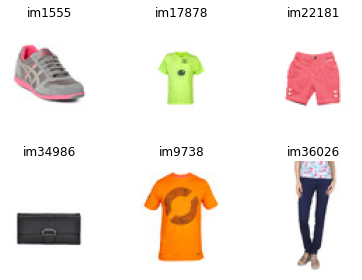

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df_train.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
print(load_image(df_train.iloc[0].image).shape)
plot_figures(figures, 2, 3)

In [ ]:
print(load_image(df_train.iloc[0].image))

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


In [ ]:
masterCategory_classes = df_train.iloc[:,2].unique()
print(masterCategory_classes)
print(len(masterCategory_classes))

['Accessories' 'Apparel' 'Personal Care' 'Footwear' 'Free Items'
 'Sporting Goods']
6
